In [ ]:
library(spatstat)

# read in the pipeline observations
sp_names <- c("OVEN", "COYE")
aru_coords <- read.csv("./inputs/aru_coords.csv")[, -1]
min_x <- min(aru_coords$x)
max_x <- max(aru_coords$x)
min_y <- min(aru_coords$y)
max_y <- max(aru_coords$y)
window <- owin(c(min_x, max_x), c(min_y, max_y))


Loading required package: spatstat.data



Loading required package: spatstat.univar

spatstat.univar 3.1-3

Loading required package: spatstat.geom

spatstat.geom 3.3-6

Loading required package: spatstat.random

spatstat.random 3.3-3

Loading required package: spatstat.explore

Loading required package: nlme

spatstat.explore 3.4-2

Loading required package: spatstat.model

Loading required package: rpart

spatstat.model 3.3-5

Loading required package: spatstat.linnet

spatstat.linnet 3.2-5


spatstat 3.3-2 
For an introduction to spatstat, type ‘beginner’ 




Warning message:
“12 points were rejected as lying outside the specified window”
Warning message:
“12 points were rejected as lying outside the specified window”
Warning message:
“12 points were rejected as lying outside the specified window”
Warning message:
“12 points were rejected as lying outside the specified window”
Warning message:
“12 points were rejected as lying outside the specified window”
Warning message:
“12 points were rejected as lying outside the specified window”
Warning message:
“12 points were rejected as lying outside the specified window”
Warning message:
“12 points were rejected as lying outside the specified window”
Warning message:
“12 points were rejected as lying outside the specified window”
Warning message:
“12 points were rejected as lying outside the specified window”
Warning message:
“12 points were rejected as lying outside the specified window”
Warning message:
“12 points were rejected as lying outside the specified window”
Warning message:
“12 points 

[1] "Observed Kcross is in the 92.81 percentile of the simulations"
[1] "Observed Kcross is in the 99.67 percentile of the simulations"


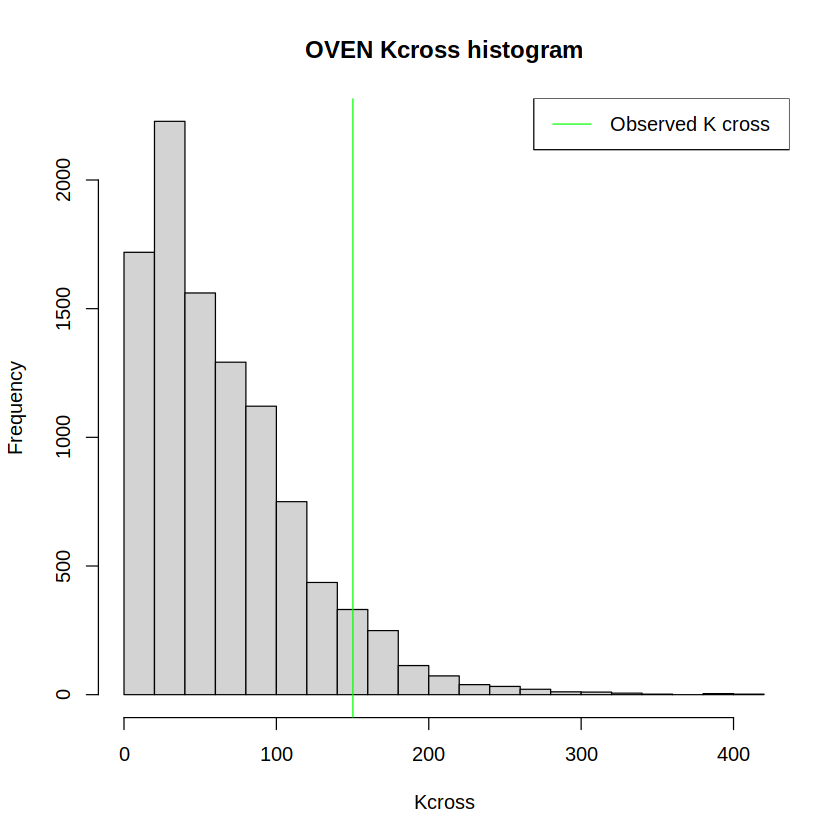

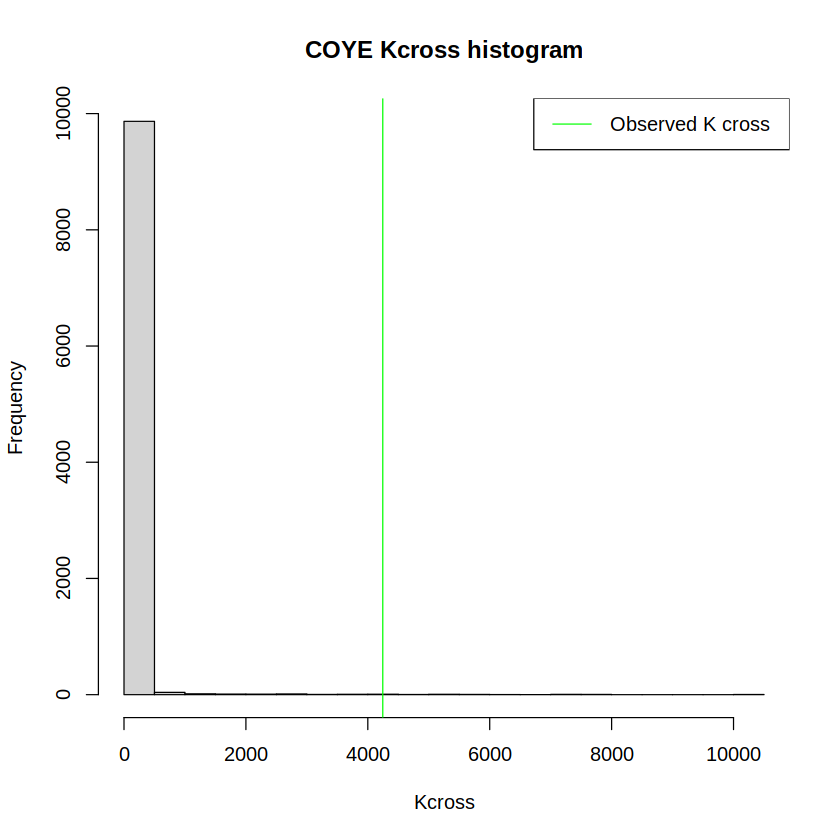

In [2]:
# ok do a toroidal shift test.
n_iterations <- 10000

# make some lists for storing the results
k_cross_results <- list()

for (sp in sp_names) {
  # read the csv "./output_data/{sp}_localizations_within_hull"
  pipeline_df <- read.csv(paste0("./output_data/", sp, "_localizations_within_hull.csv"))[, -1]
  spotmap_df <- read.csv(paste0("./output_data/", sp, "_spotmaps.csv"))[, -1]
  spotmap_df_pp <- ppp(spotmap_df$x, spotmap_df$y, window = window)
  for (k in 1:n_iterations) {
    # read the csv "./output_data/{sp}_localizations_within_hull"
    pipeline_df <- read.csv(paste0("./output_data/", sp, "_localizations_within_hull.csv"))[, -1]
    spotmap_df <- read.csv(paste0("./output_data/", sp, "_spotmaps.csv"))[, -1]
    spotmap_df_pp <- ppp(spotmap_df$x, spotmap_df$y, window = window)


    # shift the points in the pipeline_df by a random amount
    # apply rshift to the pipeline_df_pp
    pipeline_df_pp <- ppp(pipeline_df$x, pipeline_df$y, window = window)
    shifted_pipeline <- rshift(pipeline_df_pp, height = 200, width=200, edge = "torus", clip = window)
    
    marks <- factor(c(rep(2, shifted_pipeline$n), rep(1, spotmap_df_pp$n)), levels = c(1, 2))

    # make a new ppp object with the points in the same order 
    all_pp <- ppp(c(shifted_pipeline$x, spotmap_df_pp$x), c(shifted_pipeline$y, spotmap_df_pp$y), window = window, marks = marks)
    # calculate the Kcross function for r =5
    # calculate the Kcross function at r = 5
    k_cross <- Kcross(all_pp, r= c(0,5), correction = "none")
    k_cross_results[[k]] <- k_cross$un[2]
  }
  upper <- quantile(unlist(k_cross_results), 0.95)
  lower <- quantile(unlist(k_cross_results), 0.05)
  marks <- factor(c(rep(2, nrow(pipeline_df)), rep(1, nrow(spotmap_df))), levels = c(1, 2))
  real_allpp <- ppp(c(pipeline_df$x, spotmap_df$x), c(pipeline_df$y, spotmap_df$y), window = window, marks = marks)
  observed <- Kcross(real_allpp, r= c(0,5), correction = "none")
  k_el <- observed$un[2]
  # plot the results
  # and log the y axis  
  max_k <- max(c(k_el, upper, lower))
  # find what percentile observed_k_el is in 
  percentile <- sum(unlist(k_cross_results) < k_el) / n_iterations
  print(paste("Observed Kcross is in the", percentile * 100, "percentile of the simulations"))
  # plot a histogram of the kcross values
  hist(unlist(k_cross_results), main = paste(sp, "Kcross histogram"), xlab = "Kcross", ylab = "Frequency")
  # add a vertical line at the observed value
  abline(v = k_el, col = "green")
  legend("topright", legend = c("Observed K cross"), col = c("green"), lty = 1)
# save the plot
  dev.copy(png, paste0("./output_data/", sp, "_Kcross_results.png"))
  dev.off()
}
